# Sequencing of Ensemble Solutions
This notebook uses The Sequencer to analyze the ensembles produced by our 1D electrical resistivity inversions.
1. Loading the output from MATLAB

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sequencer
from scipy.io import loadmat
import h5py

In [2]:
# define the files for each model run
n_keep = 125
offset = 0 # number that gets added to all log-rho values because EMD cannot deal with negative numbers

date = "11142023"

#analysis_file_base = "../Ensembles_Constable1984_1_11082023/Analysis_Constable1984_"
#ensemble_file_base = "../Ensembles_Constable1984_1_11082023/Ensemble_Constable1984_"

#analysis_file_base = "../Ensembles_Constable_MalinvernoPrior/Analysis_Constable1984_"
#ensemble_file_base = "../Ensembles_Constable_MalinvernoPrior/Ensemble_Constable1984_"
 
analysis_file_base = "../Analysis_Constable1984_nohierarchical_"
ensemble_file_base = "../Ensemble_Constable1984_nohierarchical_"

    
def load_analysis(filename):
    with h5py.File(filename, 'r') as file:
        print(list(file.keys()))
        log_rho = np.array(file["logRhoPlot"]) # logarithm of resistivity
        xVals = np.array(file["xVals"]) # log-resistivity bins used in analyses
        zVals = np.array(file["zVals"]) # logarithm of depth
        residuals = np.array(file["residuals"])
        ewre2n = np.array(file["ewre2n"])
    return xVals, zVals, log_rho, residuals, ewre2n
              
def load_ensemble(filename):
    with h5py.File(filename, 'r') as file:        
        depth = np.array(file["results"]["ensembleDepths"])
        rho = np.array(file["results"]["ensembleRhos"])
        n_layer = np.array(file["results"]["ensembleNumLayers"])
    return depth, rho, n_layer
            
# x, z, log_rho,residuals,ewre2n = load_analysis(analysis_file)
# depth, rho, n_layer = load_ensemble(ensemble_file)

In [3]:
# Note - doing pcolor for all of logrhoplot is very very slow. That's why the code is commented out!
# plt.figure()
# plt.pcolor(log_rho)
# plt.colorbar()
# plt.show()

In [ ]:
fig,ax = plt.subplots(1,1)
h = ax.pcolorfast(log_rho_samples.T)
plt.colorbar(h)
fig.show()

In [3]:
# noise_levels = ["0.01","0.02","0.05","0.1","0.2"]
noise_levels = ["1"]
all_keep_idx = []
import os
try:
    os.mkdir(date)
except:
    pass

# Sequence the log_rho samples and SAVE THE RESULTS FOR LATER USE!!
for noise_level in noise_levels:
    #     analysis_file = "../Ensembles_09132021/Analysis3LayerA_" + noise_level + ".mat"
    #     ensemble_file = "../Ensembles_09132021/Ensemble_3LayerA_" + noise_level + ".mat"
    analysis_file = analysis_file_base + noise_level + ".mat"
    ensemble_file = ensemble_file_base + noise_level + ".mat"
    # load the ensemble:
    print("now on ensemble "+ensemble_file)
    x, z, log_rho, residuals ,ewre2n = load_analysis(analysis_file)
    depth, rho, n_layer = load_ensemble(ensemble_file)
    
    # select a subset of the ensemble:
    #keep_idx = np.random.permutation(log_rho.shape[0])[:n_keep]
    keep_idx = np.arange(0,log_rho.shape[0],int(log_rho.shape[0]/n_keep))
    all_keep_idx.append(keep_idx) # save the keep idx for later use
    log_rho_samples = log_rho[keep_idx,:]
    
    offset = np.ceil(np.min(log_rho_samples)) + 1
    print("offset=",offset)
    
    assert( np.all(log_rho_samples+offset > 0) )
    
    estimator_list = ['EMD','L2','energy']
    output_directory = date + "/sequencer_output_" + noise_level
    scale_list = [[1],[1],[1]]
    import os
    try:
        os.mkdir(output_directory)
    except:
        pass
    seq = sequencer.Sequencer(z.flatten(), log_rho_samples+offset, estimator_list,scale_list=scale_list)
    final_elongation, final_sequence = seq.execute(output_directory,                                              
                                                  to_use_parallelization=True,
                                                  to_average_N_best_estimators=True, 
                                                  number_of_best_estimators=2)
np.save(date + "/keep_indices.npy",all_keep_idx)
    


now on ensemble ../Ensemble_Constable1984_nohierarchical_1.mat
['#refs#', '#subsystem#', 'allClusterSets', 'allModels', 'allPartitions', 'binCenters', 'ewre2n', 'logRhoPlot', 'nRhoBins', 'numElements', 'nzplot', 'residuals', 'xVals', 'yVals', 'zVals']
offset= 1.0
Parallelization is ON. Number of cores: 8
calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 1.6349518299102783 seconds
calculating the distance matrices for estimator: L2, scale: 1
finished calculating this distance matrix list, it took: 0.1274869441986084 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 0.4938642978668213 seconds
dumped the distance matrix dictionaries to the file: 11142023/sequencer_output_1/distance_matrices.pkl
strating to sequence the different scales and estimators
in estimator: EMD, scale: 1


AttributeError: module 'networkx' has no attribute 'from_scipy_sparse_matrix'

In [ ]:
# LOAD THE RESULTS AND PLOT!    
all_keep_idx = np.load(date + "/keep_indices.npy")
noise_levels = ["1"]

for noise_level,keep_idx in zip(noise_levels,all_keep_idx):
    analysis_file = analysis_file_base + noise_level + ".mat"
    ensemble_file = ensemble_file_base + noise_level + ".mat"
    #analysis_file = "../Ensembles_09132021/Analysis3LayerA_" + noise_level + ".mat"
    #ensemble_file = "../Ensembles_09132021/Ensemble_3LayerA_" + noise_level + ".mat"
    # load the ensemble:
    print("now on ensemble "+ensemble_file)
    x, z, log_rho, residuals ,ewre2n = load_analysis(analysis_file)
    depth, rho, n_layer = load_ensemble(ensemble_file)
            
    # select a subset of the ensemble:
    log_rho_samples = log_rho[keep_idx,:]
    
    estimator_list = ['L2','EMD','energy']
    output_directory = date + "/sequencer_output_" + noise_level
    scale_list = [[1],[1],[1]]

    seq = sequencer.Sequencer(z.flatten(), log_rho_samples+offset, estimator_list,scale_list=scale_list)
    final_elongation, final_sequence = seq.execute(output_directory,                                              
                                                  to_average_N_best_estimators=True, 
                                                  number_of_best_estimators=2,
                                                  to_calculate_distance_matrices=False,
                                                  to_save_distance_matrices=False,
                                                  distance_matrices_inpath=output_directory + "/distance_matrices.pkl")
    
    print("intermediate elongations for the different metrics and scales:")
    estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()
    for i in range(len(estimator_list)):
        print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                       scale_list[i], 
                                                       elongation_list[i]))
        
    # PLOTTING!!
    xlabel = np.arange(n_keep)
    zlabel = (z[0][0:-1]+z[0][1:])/2.0

    vmin = np.min(log_rho_samples)
    vmax = np.max(log_rho_samples)
    #vmin = -1
    #vmax = 7

    import matplotlib.gridspec as gridspec
    estimator_list, scale_list, sequence_list = seq.return_sequence_of_weighted_products_all_metrics_and_scales()

    # fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(16,4))
    fig = plt.figure(constrained_layout=True,figsize=(12,4))
    spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
    ax0 = fig.add_subplot(spec[0, 0])
    ax1 = fig.add_subplot(spec[0, 1])
    ax2 = fig.add_subplot(spec[0, 2])
    ax3 = fig.add_subplot(spec[0, 3])

    # sequence = final_sequence
    ax0.pcolormesh(xlabel,z[0],log_rho_samples.T,vmin=vmin,vmax=vmax,rasterized=True)
    ax0.set_title("Unordered Ensemble")
    ax0.set_yscale("log")
    ax0.invert_yaxis()
    ax0.set_ylabel("Depth (m)")

    pcm = ax1.pcolormesh(xlabel,z[0],log_rho_samples[sequence_list[0],:].T,vmin=vmin,vmax=vmax,rasterized=True)
    ax1.set_title(estimator_list[0])
    ax1.set_yscale("log")
    ax1.invert_yaxis()

    ax2.pcolormesh(xlabel,z[0],log_rho_samples[sequence_list[1],:].T,vmin=vmin,vmax=vmax,rasterized=True)
    ax2.set_title(estimator_list[1])
    ax2.set_yscale("log")
    ax2.invert_yaxis()

    ax3.pcolormesh(xlabel,z[0],log_rho_samples[sequence_list[2],:].T,vmin=vmin,vmax=vmax,rasterized=True)
    ax3.set_title(estimator_list[2])
    ax3.set_yscale("log")
    ax3.invert_yaxis()
    fig.colorbar(pcm,ax=ax3,shrink=0.8)
    plt.savefig(date + "/figure_ensemble_" + noise_level + ".pdf",dpi=300)
    fig.show()

now on ensemble ../Ensembles_Constable_MalinvernoPrior/Ensemble_Constable1984_1.mat
['#refs#', '#subsystem#', 'allClusterSets', 'allModels', 'allPartitions', 'binCenters', 'ewre2n', 'logRhoPlot', 'nRhoBins', 'numElements', 'nzplot', 'residuals', 'xVals', 'yVals', 'zVals']
strating to sequence the different scales and estimators
in estimator: L2, scale: 1


(250000, 26)


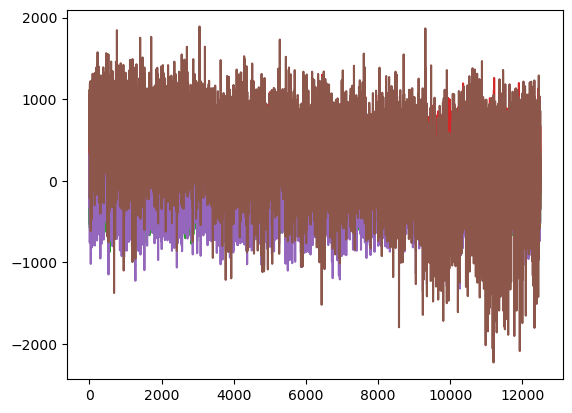

In [9]:
ewre_keep = ewre2n[keep_idx]
residual_keep = residuals[keep_idx,:]
print(residuals.shape)

plt.figure()
plt.plot(residual_keep[sequence_list[1]])
plt.show()

In [ ]:
estimator_list
scale_list
sequence_list

In [ ]:
keep_idx

(array([   7.,   94.,  543., 1673., 3549., 4128., 1774.,  590.,  130.,
          12.]),
 array([-0.88538993, -0.14301153,  0.59936688,  1.34174529,  2.08412369,
         2.8265021 ,  3.5688805 ,  4.31125891,  5.05363731,  5.79601572,
         6.53839412]),
 <BarContainer object of 10 artists>)

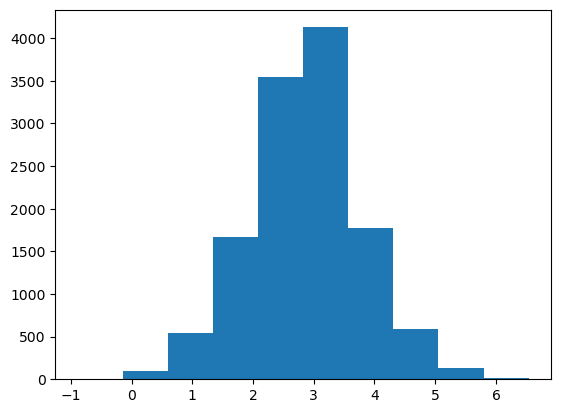

In [18]:
plt.hist(log_rho_samples[:,999].ravel())

In [16]:
log_rho_samples.shape

(12500, 1000)

In [ ]:
test = np.arange(0,log_rho.shape[0],int(log_rho.shape[0]/n_keep))
test.shape

In [ ]:
keep_idx.shape

In [ ]:
test.dtype